# LSTMs for Human Activity Recognition

Human activity recognition using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. Other research on the activity recognition dataset used mostly use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much did the data was preprocessed. 

## Video dataset overview

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<p align="center">
  <a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="Video of the experiment" width="400" height="300" border="10" /></a>
  <a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>
</p>

## Details about input data

I will be using an LSTM on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing. The dataset's description goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data: only the gravity effect has been filtered out of the accelerometer  as a preprocessing step for another 3D feature as an input to help learning. 

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of feature vectors (one vector per time step) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" />

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. 


## Results 

Scroll on! Nice visuals awaits. 

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


## Let's start by downloading the data: 

In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

#!pwd && ls
#os.chdir(DATA_PATH)
#!pwd && ls

#!python download_dataset.py

#!pwd && ls
#os.chdir("..")
#!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)



Dataset is now located at: data/UCI HAR Dataset/


## Preparing dataset:

In [4]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 16 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 2500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.0991399 0.395671
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [6]:
def LSTM_RNN(_X):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.layers.dense(_X, n_hidden, activation=tf.nn.relu)
    
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    #lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    #lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    #lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_2, lstm_cell_2], state_is_tuple=True)
    gru_cell_1 = tf.contrib.rnn.GRUCell(n_hidden)
    gru_cell_2 = tf.contrib.rnn.GRUCell(n_hidden)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([gru_cell_2, gru_cell_2], state_is_tuple=True)
    
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # no profit
    #nn = tf.layers.dense(lstm_last_output, int(n_classes * 1.5), activation=tf.nn.relu)
    
    return tf.layers.dense(lstm_last_output, n_classes)
    
    
    # Linear activation
    #return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']
    #return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']
    # bad idea
    #return tf.matmul(lstm_last_output, _weights['out'])
    # bad idea: softmax
    #return tf.nn.softmax(tf.matmul(lstm_last_output, _weights['out']) + _biases['out'])


def extract_batch(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Let's get serious and build the neural network:

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

pred = LSTM_RNN(x)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data

powed_range = lambda o, k, xsz: tf.pow(tf.constant(o), tf.to_float(tf.range(xsz)) * tf.constant(k))

sale_for_first = lambda x: tf.multiply(x, tf.constant(1.0) - powed_range(2.0, -0.5, tf.size(x)))

cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


## Hooray, now train the neural network:

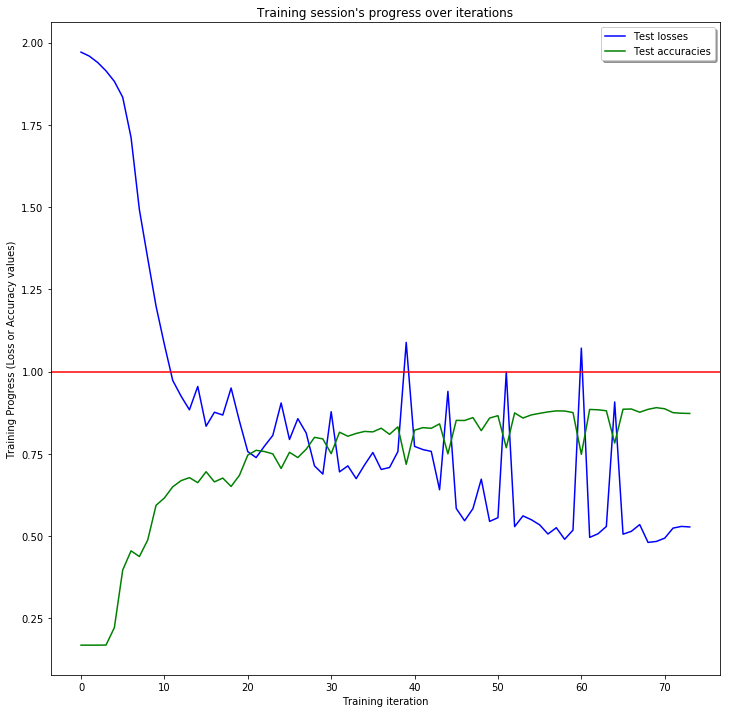

Training iter #2190000:   Batch Loss = 0.192381, Accuracy = 0.972399890422821
PERFORMANCE ON TEST SET: Batch Loss = 0.5277131795883179, Accuracy = 0.8727518320083618
Optimization Finished!
FINAL RESULT: Batch Loss = 0.5236146450042725, Accuracy = 0.8778418302536011


In [8]:
from IPython.display import clear_output
#To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
diter = 0
while step * batch_size <= training_iters:
    batch_xs =         extract_batch(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        diter += 1
        # To not spam console, show training accuracy/loss in this "if"
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)
        clear_output(True)

        width = 12
        height = 12
        plt.figure(figsize=(width, height))
        
        ixs = np.array(range(diter))
        plt.plot(ixs, np.array(test_losses),     "b-", label="Test losses")
        plt.plot(ixs, np.array(test_accuracies), "g-", label="Test accuracies")

        plt.axhline(y=1.0, c='r')

        plt.title("Training session's progress over iterations")
        plt.legend(loc='upper right', shadow=True)
        plt.ylabel('Training Progress (Loss or Accuracy values)')
        plt.xlabel('Training iteration')

        plt.show()
        
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss2) + \
              ", Accuracy = {}".format(acc2))
        
    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


In [9]:
list(zip(one_hot_predictions.argmax(axis=1), y_test.reshape(-1,), one_hot_predictions))

[(4, 4, array([ 0.64309907, -4.23426294, -1.6779182 ,  2.30835676,  5.5040369 ,
         -1.98582566], dtype=float32)),
 (4, 4, array([ 0.65003687, -4.40477753, -1.50061822,  2.30824518,  5.57092714,
         -2.11782408], dtype=float32)),
 (4, 4, array([ 0.67643392, -4.29174232, -1.53859782,  2.22610068,  5.52849722,
         -2.08826542], dtype=float32)),
 (4, 4, array([ 0.69810236, -4.31202316, -1.49770021,  2.22624135,  5.51661253,
         -2.13917685], dtype=float32)),
 (4, 4, array([ 0.69747001, -4.28895378, -1.51802349,  2.22339535,  5.514256  ,
         -2.12669373], dtype=float32)),
 (4, 4, array([ 0.69640195, -4.22633648, -1.5618012 ,  2.19187665,  5.49944687,
         -2.08473921], dtype=float32)),
 (4, 4, array([ 0.71074313, -4.19838572, -1.55008674,  2.14339995,  5.4968195 ,
         -2.11168838], dtype=float32)),
 (4, 4, array([ 0.73152834, -4.13758135, -1.5716157 ,  2.10641074,  5.46923828,
         -2.11044407], dtype=float32)),
 (4, 4, array([ 0.70627618, -4.16644764,

In [10]:
y_test

array([[4],
       [4],
       [4],
       ..., 
       [1],
       [1],
       [1]], dtype=int32)

In [11]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'dense/kernel:0' shape=(9, 16) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/candidate/kernel:0' shape=(32, 16) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/candidate/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(16, 6) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(6,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel/RMSProp:0' shape=(9, 16) dtype=float32_ref>,
 <tf.Variable 'dense/kernel/RMSProp_1:0' shape=(9, 16) dtype=float32_ref>,
 <tf.Variable 'dense/bias/RMSProp:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'dense/bias/RMSProp_1:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/gates

## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


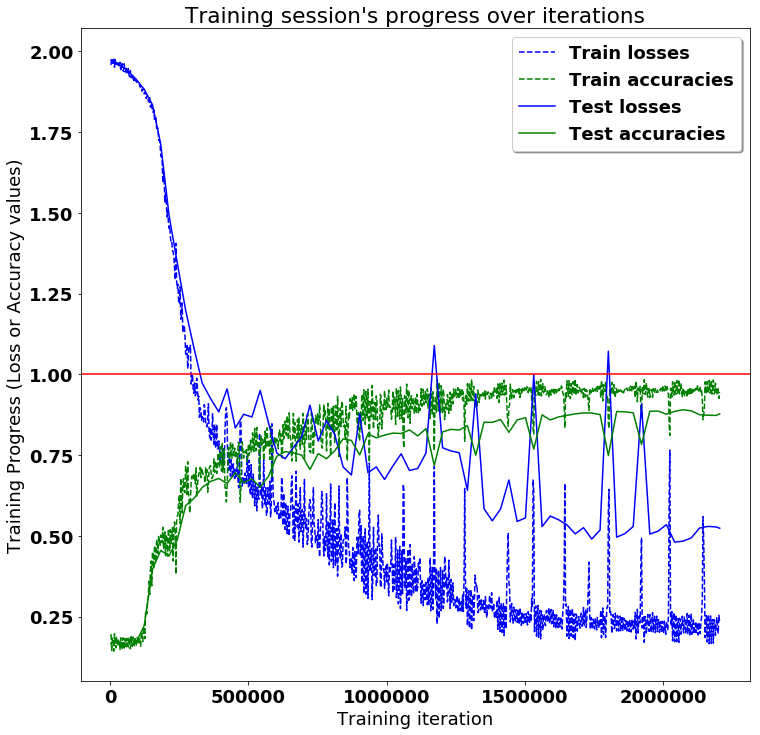

In [12]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.axhline(y=1.0, c='r')

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 87.78418302536011%

Precision: 88.07702096405018%
Recall: 87.78418730912793%
f1_score: 87.75635979228261%

Confusion Matrix:
[[459   9  28   0   0   0]
 [  6 417  47   0   0   1]
 [ 13  23 384   0   0   0]
 [  3  20   0 360 102   6]
 [  7  19   0  50 456   0]
 [  0  26   0   0   0 511]]

Confusion matrix (normalised to % of total test data):
[[ 15.57516193   0.30539531   0.95011878   0.           0.           0.        ]
 [  0.20359688  14.14998341   1.5948422    0.           0.           0.03393281]
 [  0.44112659   0.7804547   13.0302       0.           0.           0.        ]
 [  0.10179844   0.67865622   0.          12.21581268   3.46114707
    0.20359688]
 [  0.2375297    0.64472347   0.           1.69664061  15.47336292   0.        ]
 [  0.           0.88225317   0.           0.           0.          17.33966827]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


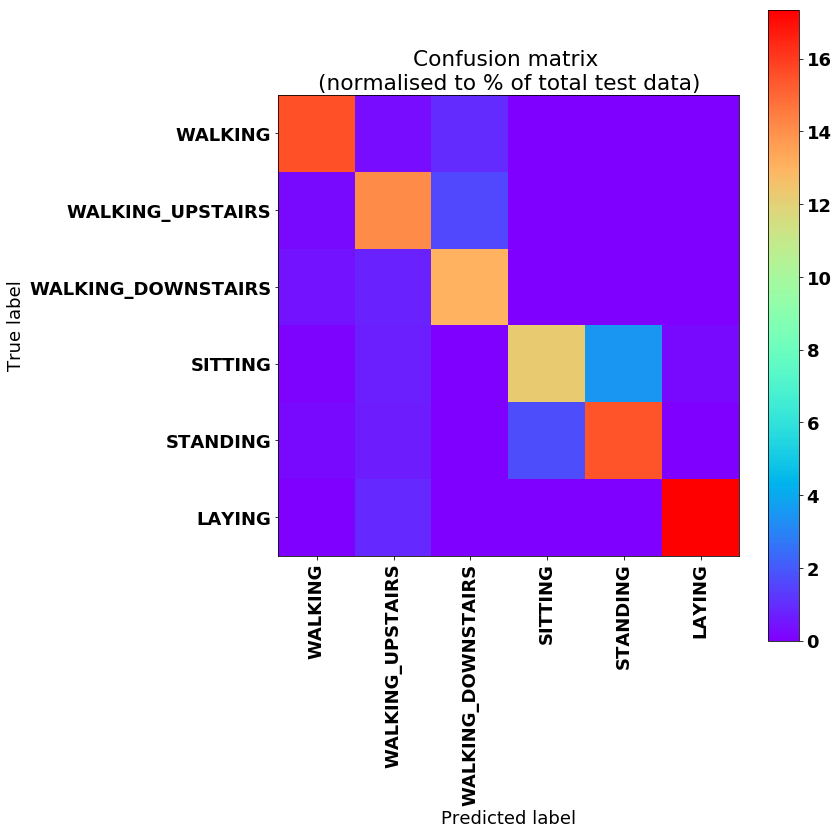

In [13]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [14]:
sess.close()

## Conclusion

Outstandingly, **the final accuracy is of 91%**! And it can peak to values such as 92.73%, at some moments of luck during the training, depending on how the neural network's weights got initialized at the start of the training, randomly. 

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so those predictions are extremely accurate.

I specially did not expect such good results for guessing between "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level according to how the dataset was gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away from the identity. This is great.

It is also possible to see that there was a slight difficulty in doing the difference between "WALKING", "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS". Obviously, those activities are quite similar in terms of movements. 

I also tried my code without the gyroscope, using only the two 3D accelerometer's features (and not changing the training hyperparameters), and got an accuracy of 87%. In general, gyroscopes consumes more power than accelerometers, so it is preferable to turn them off. 


## Improvements

In [another open-source repository of mine](https://github.com/guillaume-chevalier/HAR-stacked-residual-bidir-LSTMs), the accuracy is pushed up to 94% using a special deep LSTM architecture which combines the concepts of bidirectional RNNs, residual connections and stacked cells. This architecture is also tested on another similar activity dataset. It resembles to the architecture used in "[Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/pdf/1609.08144.pdf)" without an attention mechanism and with just the encoder part - still as a "many to one" architecture which is adapted to the Human Activity Recognition (HAR) problem.

If you want to learn more about deep learning, I have also built a list of the learning ressources for deep learning which have revealed to be the most useful to me [here](https://github.com/guillaume-chevalier/awesome-deep-learning-resources). You could as well learn to [learn to learn by gradient descent by gradient descent](https://arxiv.org/pdf/1606.04474.pdf) (not for the faint of heart). Ok, I pushed the joke deep enough... 


## References

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) can be found on the UCI Machine Learning Repository. 

> Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

To cite my work, point to the URL of the GitHub repository: 
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

My code is available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). 

## Connect with me

- https://ca.linkedin.com/in/chevalierg 
- https://twitter.com/guillaume_che
- https://github.com/guillaume-chevalier/


In [15]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] WARNING | pattern 'LSTM.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--clear-output
    Clear output of current file and save in place, 
    overwriting the existing notebook.
--execute
    Execute the notebook prior to export.
-y
    Answer yes to any questions instead of prompting.
--debug
    set log level to logging.DEBUG (maximize logging output)
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--inplace
    Run nbconvert in place, overwriting the existing notebook (only 
    relevant when converting to

In [16]:
__file__

NameError: name '__file__' is not defined